In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from tqdm import tqdm

In [2]:
def reconstruct_block(block, quantizer, data, epochs=100, lr=1e-3):
    block.eval()
    
    with torch.no_grad():
        dum_output = block(data[0:1])
    
    optimizer = optim.Adam([quantizer.s, quantizer.V], lr=lr)
    criterion = nn.MSELoss()
    
    loss_history = []
    
    for epoch in tqdm(range(epochs), desc="Reconstructing block"):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch in data.split(32):
            with torch.no_grad():
                output_fp32 = block(batch)
            output_quant = block(quantizer(batch))
            loss = criterion(output_fp32, output_quant)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"\nEpoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")
            print(f"Quantizer scale (s): {quantizer.s.item():.4f}")
            if hasattr(quantizer, 'V'):
                print(f"Quantizer offset (V) mean: {quantizer.V.mean().item():.4f}")
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()
    
    return loss_history

In [3]:
class GenieQuantizer(nn.Module):
    def __init__(self, bitwidth=4):
        super().__init__()
        self.s = nn.Parameter(torch.tensor(1.0)) 
        self.V = nn.Parameter(torch.zeros(1))     
        self.bitwidth = bitwidth
        self.is_initialized = False

    def forward(self, x):
        return self.quantize(x)

    def quantize(self, x):
        if not self.is_initialized or self.V.shape != x.shape:
            self.V = nn.Parameter(torch.zeros_like(x))
            self.is_initialized = True
            
        B = torch.floor(x / self.s.detach())  #  Eq. 9
        return self.s * (B + torch.sigmoid(self.V))  # Eq. 10

In [4]:
def get_blocks(model):
    blocks = []
    # For ResNet
    blocks.append(nn.Sequential(model.conv1, model.bn1, model.relu))
    blocks.append(model.layer1)
    blocks.append(model.layer2)
    blocks.append(model.layer3)
    blocks.append(model.layer4)
    blocks.append(nn.Sequential(
    model.avgpool,
    nn.Flatten(start_dim=1), 
    model.fc
))
    return blocks

In [5]:
def adaround(weights, quantizer, synthetic_data):
    for data in synthetic_data:
        loss = mse_loss(quantizer(weights), weights)
        loss.backward()
        quantizer.V.step()  # Only update V, not B

In [6]:
 #run when you get synthetic data from Genie D
synthetic_data = torch.load('dataset_checkpoint_final.pt', map_location=torch.device('cpu'))
synthetic_data = synthetic_data['dataset']

In [7]:
synthetic_data = torch.tensor(synthetic_data)
print(synthetic_data.shape)

torch.Size([1024, 3, 224, 224])


C:\Users\aliesk\AppData\Local\Temp\ipykernel_13616\866047346.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synthetic_data = torch.tensor(synthetic_data)


C:\Users\aliesk\anaconda3\envs\EECS6322\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aliesk\anaconda3\envs\EECS6322\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Reconstructing block:  20%|██        | 20/100 [02:14<09:02,  6.78s/it]


Epoch [20/100], Loss: 0.002752
Quantizer scale (s): 0.4789
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [04:29<06:44,  6.74s/it]


Epoch [40/100], Loss: 0.000235
Quantizer scale (s): 0.1352
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [06:44<04:28,  6.72s/it]


Epoch [60/100], Loss: 0.000005
Quantizer scale (s): 0.0195
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [08:58<02:14,  6.71s/it]


Epoch [80/100], Loss: 0.000000
Quantizer scale (s): 0.0017
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [11:12<00:00,  6.73s/it]


Epoch [100/100], Loss: 0.000000
Quantizer scale (s): 0.0002
Quantizer offset (V) mean: 0.0000


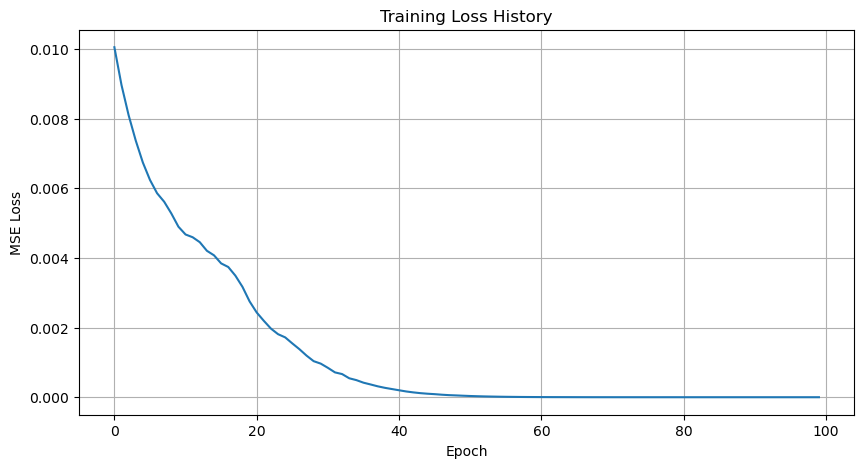

Reconstructing block:  20%|██        | 20/100 [15:02<1:00:35, 45.44s/it]


Epoch [20/100], Loss: 0.273656
Quantizer scale (s): 0.6159
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [30:11<45:20, 45.34s/it]  


Epoch [40/100], Loss: 0.269738
Quantizer scale (s): 0.5897
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [45:20<30:16, 45.40s/it]


Epoch [60/100], Loss: 0.269647
Quantizer scale (s): 0.5890
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [1:00:28<15:09, 45.46s/it]


Epoch [80/100], Loss: 0.269647
Quantizer scale (s): 0.5889
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [1:15:37<00:00, 45.37s/it]


Epoch [100/100], Loss: 0.269650
Quantizer scale (s): 0.5888
Quantizer offset (V) mean: 0.0000


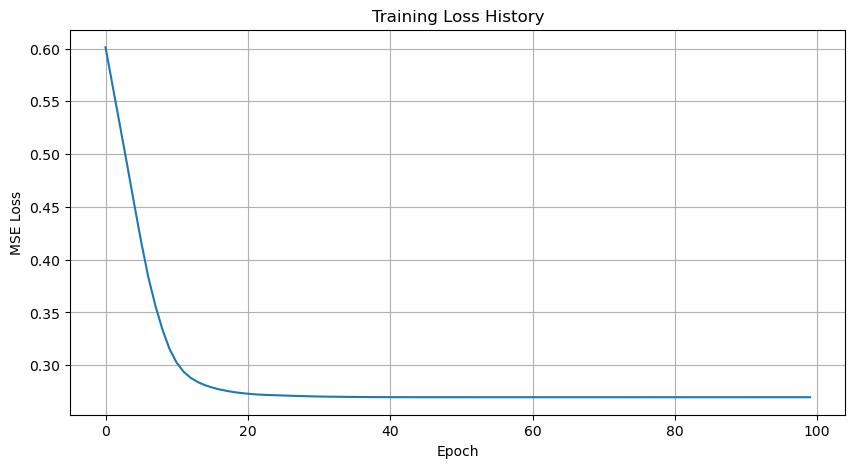

Reconstructing block:  20%|██        | 20/100 [11:55<47:44, 35.80s/it]


Epoch [20/100], Loss: 0.022887
Quantizer scale (s): 0.7475
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [23:51<35:46, 35.78s/it]


Epoch [40/100], Loss: 0.022402
Quantizer scale (s): 0.7398
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [35:46<23:49, 35.75s/it]


Epoch [60/100], Loss: 0.022402
Quantizer scale (s): 0.7400
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [47:42<11:55, 35.78s/it]


Epoch [80/100], Loss: 0.022404
Quantizer scale (s): 0.7402
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [59:39<00:00, 35.79s/it]


Epoch [100/100], Loss: 0.022406
Quantizer scale (s): 0.7404
Quantizer offset (V) mean: 0.0000


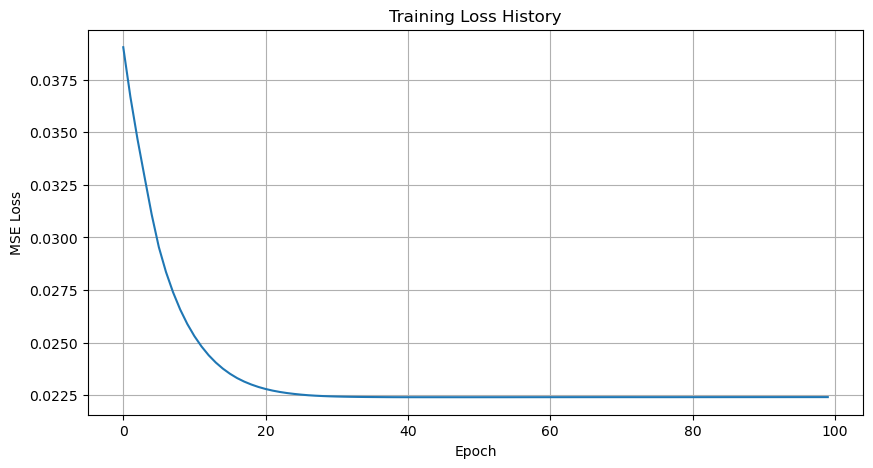

Reconstructing block:  20%|██        | 20/100 [07:42<30:48, 23.11s/it]


Epoch [20/100], Loss: 0.021065
Quantizer scale (s): 0.4429
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [15:24<23:08, 23.14s/it]


Epoch [40/100], Loss: 0.005005
Quantizer scale (s): 0.1758
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [23:08<15:26, 23.15s/it]


Epoch [60/100], Loss: 0.001642
Quantizer scale (s): 0.0997
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [30:50<07:42, 23.14s/it]


Epoch [80/100], Loss: 0.001594
Quantizer scale (s): 0.0984
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [38:33<00:00, 23.14s/it]


Epoch [100/100], Loss: 0.001594
Quantizer scale (s): 0.0985
Quantizer offset (V) mean: 0.0000


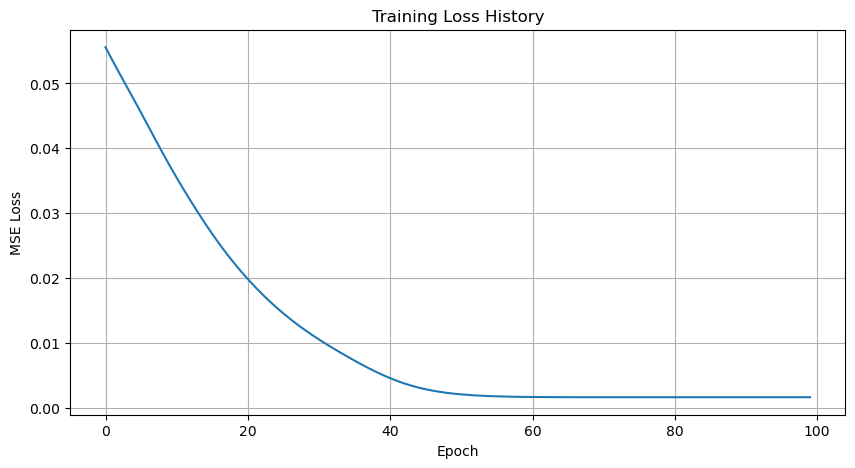

Reconstructing block:  20%|██        | 20/100 [06:31<26:05, 19.57s/it]


Epoch [20/100], Loss: 1.764522
Quantizer scale (s): 0.5453
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [13:03<19:38, 19.64s/it]


Epoch [40/100], Loss: 1.456052
Quantizer scale (s): 0.4155
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [19:37<13:05, 19.65s/it]


Epoch [60/100], Loss: 1.427580
Quantizer scale (s): 0.4032
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [26:09<06:31, 19.59s/it]


Epoch [80/100], Loss: 1.427110
Quantizer scale (s): 0.4030
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [32:42<00:00, 19.62s/it]


Epoch [100/100], Loss: 1.427126
Quantizer scale (s): 0.4030
Quantizer offset (V) mean: 0.0000


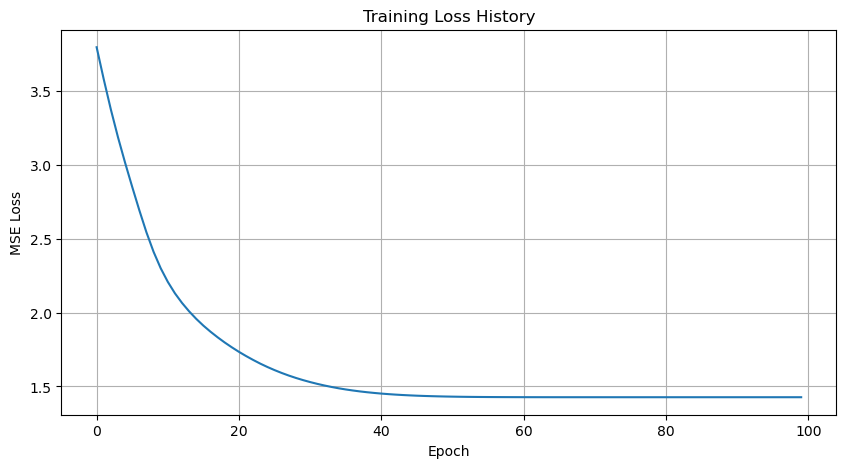

Reconstructing block:  20%|██        | 20/100 [00:07<00:28,  2.80it/s]


Epoch [20/100], Loss: 0.304849
Quantizer scale (s): 1.4927
Quantizer offset (V) mean: 0.0000


Reconstructing block:  40%|████      | 40/100 [00:14<00:21,  2.81it/s]


Epoch [40/100], Loss: 0.394381
Quantizer scale (s): 1.6758
Quantizer offset (V) mean: 0.0000


Reconstructing block:  60%|██████    | 60/100 [00:21<00:14,  2.81it/s]


Epoch [60/100], Loss: 0.408830
Quantizer scale (s): 1.7026
Quantizer offset (V) mean: 0.0000


Reconstructing block:  80%|████████  | 80/100 [00:29<00:07,  2.79it/s]


Epoch [80/100], Loss: 0.409575
Quantizer scale (s): 1.7041
Quantizer offset (V) mean: 0.0000


Reconstructing block: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


Epoch [100/100], Loss: 0.409609
Quantizer scale (s): 1.7044
Quantizer offset (V) mean: 0.0000


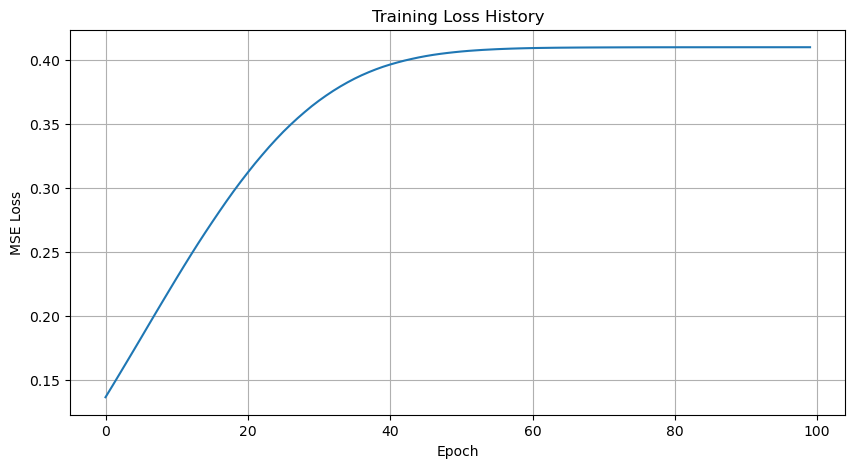

In [8]:
model = resnet18(pretrained=True).eval()
blocks = get_blocks(model) 

for block in blocks:
    quantizer = GenieQuantizer(bitwidth=4)
    reconstruct_block(block, quantizer, synthetic_data)
    with torch.no_grad():
        synthetic_data = block(synthetic_data)

In [9]:
def apply_quantization(block, quantizer):
    for name, param in block.named_parameters():
        if "weight" in name:
            param.data = quantizer.quantize(param.data)

In [10]:
apply_quantization(block, quantizer)

In [11]:
torch.save(model.state_dict(), "quantized_resnet18_100epochs.pth")
torch.save(model, "quantized_resnet18_full_100epochs.pth")